<a href="https://colab.research.google.com/github/leinerf/histopathologic-cancer-dataset/blob/master/Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<strong>Project Title: Histopathologic Cancer Detection</strong><br>
 
<strong>List of Team Members:</strong><br>
Meghana Jain, 29185439, jainm1@uci.edu<br>
Simrik Manandhar, 32369856, simrikm@uci.edu<br>
Freniel Zabala, 85881109, fzabala@uci.edu


In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from PIL import Image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, sampler
from torchvision import transforms, utils, datasets
from torch.autograd import Variable
from sklearn.metrics import precision_score, recall_score, roc_curve



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#train_labels.csv file has picture id correspondance to 0 and 1 label where 0 is no tumour tissue and 1 is there is tumour tissue

#creating a data frame

data_frame = pd.read_csv('./drive/My Drive/175 Project/train_labels.csv')
image_label_dict = {img : label for img, label in zip(data_frame.id, data_frame.label)}




In [0]:
class CancerDetectionData(Dataset):
    def __init__(self, src, datatype = 'train',
                 transform = transforms.Compose([transforms.CenterCrop(32), transforms.ToTensor()]), class_labels = dict()):
        self.src = src
        self.datatype = datatype
        self.images = [images for images in os.listdir(src)]
        self.transform = transform
        self.class_labels = class_labels

        if self.datatype == 'train':
            self.labels = [class_labels[i.split('.')[0]] for i in self.images]
        else:
            self.labels = [0 for i in range(len(self.images))]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.src, self.images[index])
        image = Image.open(img_name)
        image = self.transform(image)
        img_no_ext = self.images[index].split('.')[0]
        
        if self.datatype == 'train':
          label = self.class_labels[img_no_ext]
        else:
          label = 0
          
        return image, label


class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
      
    def __getitem__(self, index):
      print(self.num_samples)
      
    def __len__(self):
        return self.num_samples
      

def load_dataset(path, b_size, labels_dict = dict(), NUM_VAL = None, NUM_TRAIN = None):  
  
  if NUM_VAL == None and NUM_TRAIN == None:
    cancer_data = CancerDetectionData(path, 'test', class_labels = labels_dict)
    return DataLoader(cancer_data, batch_size = b_size)
  
  cancer_data = CancerDetectionData(path, 'train', class_labels = labels_dict)
  return DataLoader(cancer_data, batch_size = b_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


loader_train = load_dataset('./drive/My Drive/175 Project/datasets/Batch 2/train_2', 50, image_label_dict, 112, 0)
loader_val = load_dataset('./drive/My Drive/175 Project/datasets/Batch 2/train_2', 13, image_label_dict, 38, 112)
loader_test = load_dataset('./drive/My Drive/175 Project/datasets/Batch 2/test_2', 13)


In [0]:
#changing the datatype into GPU datatype
gpu_dtype = torch.cuda.FloatTensor

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        #print(C * H * W)
        return x.view(N, -1) 
      
neural_network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),
            Flatten(),
            nn.Linear(7200, 2)
).type(gpu_dtype)

    
neural_network_2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(2, stride=2),

            Flatten(),
            nn.Linear(16384, 2) 

).type(gpu_dtype)

loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adam(neural_network.parameters(), lr=1e-3)

In [0]:
#print_every = 100

def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            #if (t + 1) % print_every == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    precision = []
    recall = []
    fpr_arr = []
    tpr_arr = []
    thresholds_arr = None
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        precision.append( precision_score(y, preds) )
        recall.append( recall_score(y, preds) )
        fpr, tpr, thresholds = roc_curve(y, preds)
       
        thresholds_arr = thresholds
        fpr_arr.append(fpr)
        tpr_arr.append(tpr)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('Precision: %f' % (sum(precision)/len(precision)))
    print('Recall: %f' % (sum(recall)/len(recall)))
    
    return precision, recall, thresholds_arr, fpr_arr, tpr_arr
  
def plot_precision_recall(recall, precision, thresholds):
    print(thresholds)
    plt.plot(thresholds, precision, 'b--', label = 'precision')
    plt.plot(thresholds, recall, 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')

Starting epoch 1 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 2 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 3 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 4 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 5 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 6 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 7 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 8 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 9 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Starting epoch 10 / 10
t = 1, loss = 0.0002
t = 2, loss = 0.0002
t = 3, loss = 0.0001
Got 28 / 38 correct (73.68)
Precision: 0.694444
Recall: 0.688889
[2 1 0]


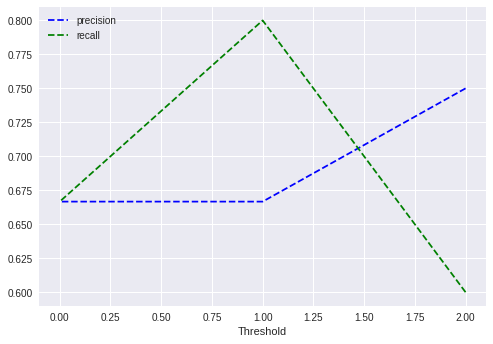

In [0]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
#neural_network.apply(reset)
train(neural_network, loss_fn, optimizer, num_epochs=10)
precision, recall, thresholds, fpr, tpr = check_accuracy(neural_network, loader_val)

plot_precision_recall(recall, precision, thresholds)
plt.show()

In [0]:
y = [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
preds = [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]

true_positive = 3
false_positive = 1
false_negative = 2

print(precision_score(y, preds))
print(recall_score(y, preds))

0.75
0.6
